Use data from
1. `9.investigate_editorial/2.editor_paper_citation_without_editorials.ipynb`
2. `12.revise%20and%20resubmit/0.preprocess.ipynb#Calculate-H-index`

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy import stats

import sys
sys.path.append('../src')
from mylogbin import mylogbin

In [2]:
%%time
author_career = pd.read_csv('/scratch/fl1092/capstone/conflated/AuthorEraDisp.csv',
            sep='\t', memory_map=True,
            usecols=['NewAuthorId', 'Parent', 'Yfp'],
            dtype={'NewAuthorId':int, 'Yfp':int, 'Ylp':int, 'Parent':int})
print(author_career.shape)

field_name = pd.read_csv("/scratch/fl1092/capstone/advanced/FieldsOfStudy.txt", sep="\t",
                        names = ["FieldOfStudyId", "Rank", "NormalizedName", "DisplayName",
                                 "MainType", "Level", "PaperCount", "CitationCount", "CreatedDate"],
                       usecols=['FieldOfStudyId','DisplayName'])

(120948543, 3)
CPU times: user 21.9 s, sys: 8.37 s, total: 30.2 s
Wall time: 30.5 s


In [3]:
top_aff = pd.read_csv('/scratch/fl1092/capstone/revise/AffiliationTop100.csv',sep='\t',
                     dtype={'NewAuthorId':int,'Year0':int,'Top100':int})

hindex = pd.read_csv('/scratch/fl1092/capstone/revise/H-index.csv',sep='\t',
                    dtype={'NewAuthorId':int,'Year':int,'Hindex':int})

prior_paper = pd.read_csv('/scratch/fl1092/capstone/elsevier/EditorPriorPaperCountNoEditorial.csv',sep='\t',
                         dtype={'NewAuthorId':int, 'PaperCount':int, 'Year':int})


prior_citaiton = pd.read_csv('/scratch/fl1092/capstone/elsevier/EditorPriorCitationCountNoEditorial.csv', sep='\t',
                            dtype={'NewAuthorId':int, 'CitationCount':int, 'Year':int})

colab_count = pd.read_csv('/scratch/fl1092/capstone/revise/ColabCount.csv',sep='\t',
                         dtype={'NewAuthorId':int, 'Year0': int, 'ColabCount':int})

print(prior_paper.shape, prior_citaiton.shape, hindex.shape, colab_count.shape, top_aff.shape)
# (625037, 3) (589264, 3) (19269, 3) (19365, 3) (14573, 3)

(625037, 3) (589264, 3) (19269, 3) (19365, 3) (14573, 3)


In [4]:
def loadManual():
    df = pd.read_csv('/scratch/fl1092/capstone/revise/RevisionReSampled_Nov_manually_done.csv', sep=',').reset_index()
    df = df.rename(columns={'index':'IND'})
    
    df = df[~df.NewAuthorId.isna()]
    
    df = df[['issn','year_min','year_max','NewAuthorId','NetID','IND','NormalizedName']].rename(
        columns={'year_min':'start_year', 'year_max':'end_year'}
    )

    df = df.assign(NewAuthorId = df.NewAuthorId.astype(int))
    df = df.assign(NewAuthorId = df.NewAuthorId.astype(int))

    df = df.assign(issn = df.issn.apply(lambda x: '0'*(8-len(x)) + x))
    
    return df

def gatherStats(df):
    df = df.assign(Year = df.start_year - 1)
    
    df = df.merge(hindex, on=['NewAuthorId','Year'], how='left').fillna(0)
    df = df.merge(prior_paper, on=['NewAuthorId','Year'], how='left').fillna(0)
    df = df.merge(prior_citaiton, on=['NewAuthorId','Year'], how='left').fillna(0)
    df = df.merge(colab_count, on=['NewAuthorId','Year'], how='left').fillna(0)
    df = df.merge(top_aff, on=['NewAuthorId','Year'], how='left').fillna(0)
    
    df = df.merge(author_career, on='NewAuthorId')
    df = df.merge(field_name.rename(columns={'FieldOfStudyId':'Parent'}), on='Parent')
    df = df.assign(Age = df.start_year - df.Yfp + 1)
    
    return df

In [5]:
def printCol(df1, df2, col):
    p = ttest_ind(df1[col], df2[col]).pvalue
    print(round(df1[col].mean(), 3), round(df2[col].mean(), 3), round(p, 4), col)

In [6]:
from matplotlib import pyplot as plt

In [7]:
manual = loadManual()

editors = pd.read_csv("/scratch/fl1092/capstone/elsevier/editors.csv", sep='\t',
                     usecols=["NewAuthorId", "issn", "start_year", "end_year"],
                     dtype={"NewAuthorId":int, "issn":str, "start_year":int, "end_year":int})

all_editors = pd.concat(
    [ editors[['NewAuthorId','start_year']], manual[['NewAuthorId','start_year']] ], ignore_index=True, sort=False
)

all_editors = all_editors.assign(Year = all_editors.start_year - 1) # year0

all_editors = all_editors.drop_duplicates()

In [8]:
%%time
manual = gatherStats(manual)

CPU times: user 37.9 s, sys: 10.2 s, total: 48 s
Wall time: 48.2 s


In [9]:
%%time
editors = gatherStats(editors)

CPU times: user 40.2 s, sys: 10.2 s, total: 50.4 s
Wall time: 50.7 s


In [10]:
for outcome in ['PaperCount','CitationCount','Hindex','Age', 'ColabCount', 'Top100']:
    printCol(editors, manual, outcome)
# 99.725 112.447 0.5171 PaperCount
# 1730.819 2484.095 0.0108 CitationCount
# 15.492 17.292 0.0297 Hindex
# 20.401 21.303 0.1365 Age
# 828.983 605.92 0.8804 ColabCount
# 0.315 0.261 0.0609 Top100

# 99.725 113.892 0.4827 PaperCount
# 1730.819 2572.42 0.0056 CitationCount
# 15.492 17.58 0.0141 Hindex
# 20.401 21.428 0.0989 Age
# 828.983 623.244 0.8926 ColabCount
# 0.315 0.264 0.0827 Top100

99.725 112.447 0.5171 PaperCount
1730.819 2484.095 0.0108 CitationCount
15.492 17.292 0.0297 Hindex
20.401 21.303 0.1365 Age
828.983 605.92 0.8804 ColabCount
0.315 0.261 0.0609 Top100


In [13]:
manual.shape, editors.shape

((264, 17), (19741, 14))

In [11]:
manual.head()

,issn,start_year,end_year,NewAuthorId,NetID,IND,NormalizedName,Year,Hindex,PaperCount,CitationCount,ColabCount,Top100,Yfp,Parent,DisplayName,Age
0,10452354,2011,2011,61955298,ma5938,0,patricia j arnold,2010,9.0,16.0,356.0,14.0,0.0,1991,162324750,Economics,21
1,03043932,1975,1977,86969796,ma5938,11,harry g johnson\t,1974,1.0,1.0,9.0,0.0,0.0,1972,162324750,Economics,4
2,03043878,2011,2014,21512192,ma5938,14,kaivan munshi,2010,11.0,32.0,927.0,33.0,1.0,1993,162324750,Economics,19
3,01448188,1988,1991,66668588,ma5938,34,paul l joskow,1987,13.0,53.0,509.0,39.0,1.0,1972,162324750,Economics,17
4,22104224,2011,2019,15773488,AutoMatched,107,john m gowdy,2010,22.0,161.0,1474.0,187.0,0.0,1979,162324750,Economics,33


In [12]:
editors.head()

,NewAuthorId,issn,start_year,end_year,Year,Hindex,PaperCount,CitationCount,ColabCount,Top100,Yfp,Parent,DisplayName,Age
0,1291,00142921,2005,2009,2004,7.0,18.0,155.0,9.0,0.0,1983,162324750,Economics,23
1,2628,15723089,2010,2019,2009,12.0,128.0,1073.0,107.0,0.0,1987,162324750,Economics,24
2,4070,00401625,2015,2019,2014,21.0,176.0,1543.0,376.0,0.0,1992,162324750,Economics,24
3,4070,00487333,2014,2019,2013,20.0,163.0,1327.0,346.0,0.0,1992,162324750,Economics,23
4,4367,01678116,2012,2015,2011,10.0,27.0,534.0,42.0,1.0,1995,162324750,Economics,18


# Plot

In [11]:
import matplotlib
import scipy.stats as st
import scipy

font = {'size': 7}
matplotlib.rc('font', **font)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['axes.linewidth'] = 0.5

In [12]:
def calcHeight(ys, confidence=0.95):
    means = [y.mean() for y in ys]
    errs = [st.sem(y)*st.t.ppf((1 + confidence) / 2., y.shape[0]-1) for y in ys]
    
    return max(means[0] +errs[0], means[1]+errs[1])

def plotPvalue(ax, x, y, pVal, ytop, lw=0.2, c='black'):
    # x: [x0, x1]
    # y: [y0, y1]
    height = max(y[0], y[1])
    gap = ytop * 0.01
    vlength = ytop * 0.03
    
    yPos = height + gap + vlength
    ax.hlines(yPos, x[0], x[1], color=c, lw=lw)
    ax.vlines(x[0], height + gap, yPos, color=c, lw=lw)
    ax.vlines(x[1], height + gap, yPos, color=c, lw=lw)
    
    stars = '***' if pVal < 0.001 else '**' if pVal < 0.01 else '*' if pVal < 0.05 else f'p={round(pVal, 2)}'
    offset = 0.01 if pVal < 0.05 else 0.04
    
    ax.text((x[0] + x[1])/2, yPos + offset*ytop, stars, ha='center', color=c)

def plotBar(ax, ys, ytop, confidence=0.95, showP=True):
    colors = ['#ff7f00', '#1f78b4']
    
    means = [y.mean() for y in ys]
    errs = [st.sem(y)*st.t.ppf((1 + confidence) / 2., y.shape[0]-1) for y in ys]
    p_value = scipy.stats.ttest_ind(ys[0], ys[1])
    
    x = [i+1 for i in range(len(ys))]
    
    ax.bar(x, means, width = 0.6, yerr=errs, color=colors, error_kw={'elinewidth':0.5}, linewidth=0.2,
           edgecolor=['black','black'])
    
    if showP:
        height = [means[i] + errs[i] for i in range(len(ys))]
        
        plotPvalue(ax, x, height, p_value.pvalue, max(height))

In [13]:
# old color scheme: #fc8d59 and 91bfdb

def cumSum(x):
    s = 0
    res = [x[0]]
    for i in x:
        s += i
        res.append(s)
        
    return res

def plotFieldDist(df, ax):
    x = [x for x in range(19)]
    x1 = [_-0.2 for _ in x]
    x2 = [_+0.2 for _ in x]
    
    ax.bar(x = x1, height=df.ManualCount.values, width=0.4, color='#1f78b4', label='Manual' )
    ax.bar(x = x2, height=df.RealCount.values, width=0.4, color='#ff7f00', label='MAG-matched')
    
    ax.set_xticks(x)
    ax.set_xticklabels(fields_count.Field.values)
    
    plt.xticks(rotation=90)

def plotLogBin(a, b, ax, base, step=10):
    
    a1 = a.to_numpy().copy()
    a2 = b.to_numpy().copy()
    
    x1, h1 = mylogbin(a1, base)
    x2, h2 = mylogbin(a2, base)
    
    
    ax.plot(x2, h2, marker = 'o', ls='None', markersize=2, color='#1f78b4', label='MAG-matched')
    ax.plot(x1, h1, marker = '^', ls='None', markersize=2, color='#ff7f00', label='Manual')

def plotHist(a, b, ax, step, lo, hi):
    
    x1, h1 = normalizeHist(a, step, lo, hi)
    x2, h2 = normalizeHist(b, step, lo, hi)
    
    x1 = [_-step*0.25 for _ in x1]
    x2 = [_+step*0.25 for _ in x2]
    
    
    ax.bar(x2, h2, width=step*0.5, color='#1f78b4', label='MAG-matched')
    ax.bar(x1, h1, width=step*0.5, color='#ff7f00', label='Manual')

def normalizeHist(values, step, lo, hi):
    x, y = [], []
    prev = 0
    
    for i in range(lo, hi, step):
        x.append(i)
        y.append(values[values <= i].shape[0]-prev)
        prev = values[values <= i].shape[0]
        
    y = [_/values.shape[0] for _ in y]
    
    return x, y

In [14]:
def styleAx(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(b=True, ls=':')

In [15]:
def printPvalue(ax, outcome, dfa = editors, dfb = manual, x=0.2, y=0.45):
    pVal = ttest_ind(dfa[outcome], dfb[outcome]).pvalue
    
    p = f'p={round(pVal, 2)}'
    
    ax.text(x, y, p, transform=ax.transAxes, fontsize=8)

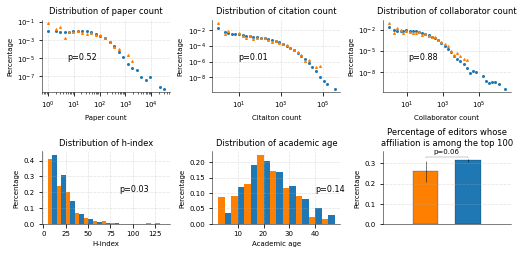

In [16]:
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(18.3*cm, 9*cm))


ax = plt.subplot(2, 3, 1)
ax.title.set_text('Distribution of paper count')
styleAx(ax)
ax.set_xscale('log')
ax.set_yscale('log')
plotLogBin(manual.PaperCount, editors.PaperCount, ax, 1.5)
ax.set_xlabel('Paper count')
ax.set_ylabel('Percentage')
printPvalue(ax, 'PaperCount')

ax = plt.subplot(2, 3, 2)
ax.title.set_text('Distribution of citation count')
styleAx(ax)
ax.set_xscale('log')
ax.set_yscale('log')
plotLogBin(manual.CitationCount, editors.CitationCount, ax, 1.5)
ax.set_ylabel('Percentage')
ax.set_xlabel('Citaiton count')
printPvalue(ax, 'CitationCount')

ax = plt.subplot(2, 3, 3)
ax.title.set_text('Distribution of collaborator count')
styleAx(ax)
styleAx(ax)
ax.set_xscale('log')
ax.set_yscale('log')
plotLogBin(manual.ColabCount, editors.ColabCount, ax, 1.5)
ax.set_xlabel('Collaborator count')
ax.set_ylabel('Percentage')
printPvalue(ax, 'ColabCount')

ax = plt.subplot(2, 3, 4)
ax.title.set_text('Distribution of h-index')
styleAx(ax)
plotHist(manual.Hindex, editors.Hindex, ax, 10, 10, 135)
ax.set_ylabel('Percentage')
ax.set_xlabel('H-index')
printPvalue(ax, 'Hindex', x=0.6)

ax = plt.subplot(2, 3, 5)
ax.title.set_text('Distribution of academic age')
styleAx(ax)
plotHist(manual.Age, editors.Age, ax, 5, 5, 50)
ax.set_ylabel('Percentage')
ax.set_xlabel('Academic age')
printPvalue(ax, 'Age', x=0.8)

ax = plt.subplot(2, 3, 6)
ax.title.set_text('Percentage of editors whose\naffiliation is among the top 100')
styleAx(ax)
plotBar(ax, [manual.Top100, editors.Top100], 0.4)
ax.set_ylim(0, 0.36)
ax.set_xlim(0, 3)
ax.set_xticks([])
ax.set_ylabel('Percentage')

# ax = plt.subplot(2, 1, 2)
# styleAx(ax)
# plotFieldScatter(ax)
# sp = stats.spearmanr(fields_count.RealCount, fields_count.ManualCount)
# ax.text(0.002, 0.2, f'r={round(sp.correlation, 2)}, p={round(sp.pvalue, 2)}')

plt.tight_layout()
# TODO in Illustrator: change 10^-3 to 0
plt.savefig('../figures/revise_representativeness_MAG.pdf', bbox_inches = 'tight', pad_inches = 0)